In [3]:
# import required libraries
import pandas as pd
import numpy as np
import ccxt
from ta import trend
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import yfinance as yf
from ta import trend
from pymoo.visualization.scatter import Scatter
import random
from deap import base, creator, tools, algorithms
from deap.tools import uniform_reference_points
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Constants
FEE = 0.02
START_BALANCE = 100

In [5]:
def fetch_data(timeframe, ticker):
    exchange = ccxt.kraken()
    start_timestamp = 1451606400000  # timestamp for 1 Jan 2016 - this doesn't seem to apply with kraken so we take the earliest date available.
    end_timestamp = 1651392000000  # timestamp for 1 May 2023
    interval_seconds = exchange.parse_timeframe(timeframe)  # convert timeframe to seconds
    limit = int((end_timestamp - start_timestamp) / interval_seconds) + 1
    ohlcv = exchange.fetch_ohlcv(ticker, timeframe=timeframe, since=start_timestamp, limit=limit)
    return ohlcv

# get asset prices
ohlcv = fetch_data('1d','BTC/AUD')

df = pd.DataFrame(ohlcv)
df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
df['time'] = pd.to_datetime(df['time'], unit='ms')
df

,time,open,high,low,close,volume
0,2021-05-24,45405.2,51636.1,44408.0,50154.2,31.160977
1,2021-05-25,50480.4,51535.4,47241.3,49280.8,28.347923
2,2021-05-26,49644.6,52721.0,49086.0,50652.3,34.723634
3,2021-05-27,50748.9,52154.7,48000.0,49789.2,17.808706
4,2021-05-28,49650.0,50416.3,45250.3,46355.4,18.240642
...,...,...,...,...,...,...
715,2023-05-09,40914.8,41264.3,40631.3,40967.9,15.387367
716,2023-05-10,40948.7,41834.2,39757.9,40841.1,17.907335
717,2023-05-11,40797.9,40970.2,40034.4,40365.2,10.039696
718,2023-05-12,40387.4,40476.0,38939.7,40346.3,15.123124


In [6]:
def strategy(df, length = 20, mult = 2.0,length_KC = 20, mult_KC = 2.0, stop_loss_pct = 0.05, take_profit_pct=0.05, visualise=False):

    # Prevent genetic algorithm from providing float values instead of required integer values
    length = int(length)
    length_KC = int(length_KC)

    # Array for storing running balance
    running_balance = []

    #Calculate percent change
    epsilon = 1e-8  # Prevents divide by zero errors in genetic algorithm
    df['change'] = df['close'].pct_change(1).fillna(epsilon)

    # calculate Bollinger Bands
    m_avg = trend.sma_indicator(df['close'],window=length)
    #m_avg = df['close'].rolling(window=length).mean()
    m_std = df['close'].rolling(window=length).std(ddof=0)
    df['upper_BB'] = m_avg + mult * m_std
    df['lower_BB'] = m_avg - mult * m_std

    # calculate true range
    df['tr0'] = abs(df["high"] - df["low"])
    df['tr1'] = abs(df["high"] - df["close"].shift())
    df['tr2'] = abs(df["low"] - df["close"].shift())
    df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)

    # calculate Keltner Channels
    range_ma = df['tr'].rolling(window=length_KC).mean()
    df['upper_KC'] = m_avg + range_ma * mult_KC
    df['lower_KC'] = m_avg - range_ma * mult_KC

    # calculate bar value
    highest = df['high'].rolling(window = length_KC).max()
    lowest = df['low'].rolling(window = length_KC).min()
    m1 = (highest + lowest)/2
    df['value'] = (df['close'] - (m1 + m_avg)/2)
    fit_y = np.array(range(0,length_KC))
    df['value'] = df['value'].rolling(window = length_KC).apply(lambda x:
                              np.polyfit(fit_y, x, 1)[0] * (length_KC-1) +
                              np.polyfit(fit_y, x, 1)[1], raw=True)

    # check for 'squeeze'
    df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
    df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])

    # buying window for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1 = (df['squeeze_off'].shift(2)  == False) & (df['squeeze_off'].shift(1)  == True)
    # 2. bar value is positive => the bar is light green k
    long_cond2 = df['value'].shift(1)  > 0
    df['enter_long'] = long_cond1 & long_cond2

    # buying window for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1 = (df['squeeze_off'].shift(2) == False) & (df['squeeze_off'].shift(1)  == True)
    # 2. bar value is negative => the bar is light red
    short_cond2 = df['value'].shift(1)  < 0
    df['enter_short'] = short_cond1 & short_cond2

    # Calculate stop-loss and take-profit prices for long positions
    in_long_position = False
    in_short_position = False
    cumulative_return = 1.0
    current_trade_return = 1.0
    all_trades = []

    num_trades = 0
    invalid_run = False

    for i in range(1, len(df)):
        # Long trades
        if df['enter_long'][i] == True and not in_short_position and not in_long_position:
            in_long_position = True
            cumulative_return *= (1 - FEE)
            current_trade_return = 1.0
            num_trades += 1

        elif in_long_position:
            current_trade_return *= (1 + df['change'][i])
            if (current_trade_return >= (1+take_profit_pct) or current_trade_return <= (1-stop_loss_pct)):
                in_long_position = False
                cumulative_return *= current_trade_return
                if visualise:
                    print(f'Long return: {current_trade_return - 1}, current total: {cumulative_return}')
                all_trades.append(current_trade_return)
                current_trade_return = 1.0

        # Short trades
        if df['enter_short'][i] == True and not in_long_position and not in_short_position:
            in_short_position = True
            cumulative_return *= (1 - FEE)
            current_trade_return = 1.0
            num_trades += 1

        elif in_short_position:
            current_trade_return *= (1 - df['change'][i])
            if (current_trade_return >= (1+take_profit_pct) or current_trade_return <= (1-stop_loss_pct)):
                in_short_position = False
                cumulative_return *= current_trade_return
                if visualise:
                    print(f'Short return: {current_trade_return - 1}, current total: {cumulative_return}')
                all_trades.append(current_trade_return-1)
                current_trade_return = 1.0
        running_balance.append(cumulative_return*100)

    total_risk = np.std(all_trades)

    if visualise:
        print(f"Total Return: {round(START_BALANCE*(cumulative_return),2)}'\n'Net Profit: {round((cumulative_return-1)*100,2)}%'\n'Risk: {round(np.std(all_trades)*100,2)}%")
        plt.plot(running_balance)
    if num_trades < 5:
        # We do not consider trading simulations with less than five trades to be valid, as this is neither good enough as a trading strategy over out time frame and it causes erroneous sharpe ratios
        # I.e., a simulation with only a single trade has a standard deviation of zero, causing a divide by zero error
        invalid_run = True


    return (cumulative_return-1), total_risk, invalid_run

Long return: 0.06382467044613516, current total: 1.0425481770372125
Short return: -0.09028343747170142, current total: 0.9294548770067482
Short return: -0.06538210221045382, current total: 0.8513114599735225
Long return: -0.098841545554477, current total: 0.7518231891310713
Short return: 0.053220232657286815, current total: 0.7759986862902948
Short return: -0.058396456535188435, current total: 0.7160694504802806
Short return: 0.12609062587325726, current total: 0.7902319137468573
Long return: -0.08725696531576466, current total: 0.7068531015564847
Short return: 0.06907304886266208, current total: 0.7405640483714396
Short return: 0.10188802034310718, current total: 0.799698280133337
Long return: -0.08847265325983111, current total: 0.7143679144529647
Short return: 0.055000009614494694, current total: 0.7385849934838409
Short return: 0.0519414764437478, current total: 0.7614092247540957
Long return: -0.10710624359262866, current total: 0.6662603919968307
Long return: 0.05496383229997037,

(-0.47533967455274917, 0.4705378022273993, False)

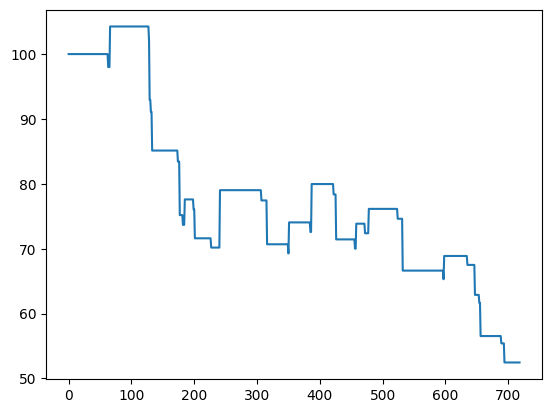

In [7]:
# Example of strategy performance
# Note - trade returns will often largely exceed take-profit and stop-loss due to market moves exceeding set limits too quickly
strategy(df, visualise=True)

gen	nevals	avg                      	std                    	min                      	max                    
0  	100   	[-0.38906755  1.94388557]	[0.27036998 0.29037742]	[-0.80790697  1.        ]	[0.21936282 2.37728424]
1  	91    	[-0.22759976  1.92144333]	[0.26528482 0.36536536]	[-0.76741607  1.        ]	[0.71639365 2.37728424]
2  	88    	[-0.09209787  1.8650881 ]	[0.21313096 0.46166995]	[-0.76741607  1.        ]	[0.71639365 2.74186233]
3  	92    	[-0.04481049  2.05054056]	[0.23301724 0.3144859 ]	[-0.72601404  1.        ]	[0.71639365 2.74186233]
4  	88    	[-0.00478758  2.14453651]	[0.25812453 0.20674281]	[-0.72601404  1.82610367]	[0.71639365 2.90287239]
5  	95    	[0.03526392 2.1965359 ]  	[0.28228575 0.22649528]	[-0.58136419  1.77797338]	[0.82151377 2.90287239]
6  	93    	[0.12565603 2.26074088]  	[0.29520495 0.2631364 ]	[-0.55939775  1.77797338]	[1.00041502 3.02098699]
7  	92    	[0.17214561 2.3300655 ]  	[0.32376811 0.25867851]	[-0.40939096  1.86055958]	[1.19075073 3.02098699]
8

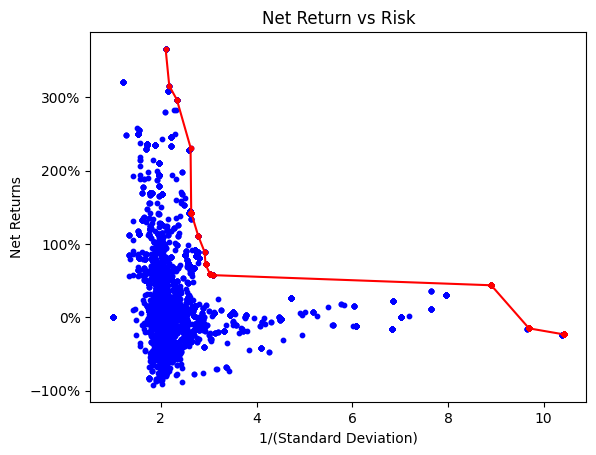

In [10]:
# NSGA-II Algorithm

fitness_results = []
pareto_values = []
strategy_parameters = {}

creator.create("FitnessMulti", base.Fitness, weights=(1.0,1.0))

creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("length", random.randint, 5, 20)
toolbox.register("mult", random.uniform, 1.25, 3.5)
toolbox.register("length_KC", random.randint, 5, 20)
toolbox.register("mult_KC", random.uniform, 1.25, 3.5)
toolbox.register("stop_loss_pct", random.uniform, 0.01, 0.1)
toolbox.register("take_profit_pct", random.uniform, 0.01, 0.1)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.length, toolbox.mult, toolbox.length_KC,
                  toolbox.mult_KC, toolbox.stop_loss_pct, toolbox.take_profit_pct), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



def evaluate(individual):
    # Convert individual to a tuple before unpacking
    length, mult, length_KC, mult_KC, stop_loss_pct, take_profit_pct = tuple(individual)
    
    # Call the strategy function
    net_profit, std_dev, invalid_run = strategy(df, length, mult, length_KC, mult_KC, stop_loss_pct, take_profit_pct)
    
    # Check for invalid run
    if invalid_run:
        net_profit = 0.0
        std_dev = 1.0  # You may replace this with any default value

    # Append the results
    fitness_results.append((net_profit, 1/std_dev))
    strategy_parameters[(net_profit, 1/std_dev)] = (length, mult, length_KC, mult_KC, stop_loss_pct, take_profit_pct)

    # Return the tuple of fitness values
    return net_profit, 1/std_dev


toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", evaluate)


def main():
    random.seed(42)
    NGEN = 100      # Number of generations
    MU = 100         # Population Size
    LAMBDA = 100    # Number of children produced each generation
    CXPB = 0.7      # Crossover rate
    MUTPB = 0.2     # Mutation Probability

    pop = toolbox.population(n=MU)
    hof = tools.ParetoFront()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                                             halloffame=hof)

    return pop, logbook, hof

if __name__ == "__main__":

    pop, log, hof = main()
    print(pop)
    print("Best solutions found on the Pareto front:")
    for ind in hof:
        if ind.fitness.values[0] != 'nan':
            print(f" Fitness: {ind.fitness.values}")
            pareto_values.append(ind.fitness.values)
    

    # Visualisation of Results
    fitness_x = [t[1] for t in fitness_results]
    fitness_y = [t[0] for t in fitness_results]
    pareto_x = [t[1] for t in pareto_values]
    pareto_y = [t[0] for t in pareto_values]
    fitness_y = [y * 100 for y in fitness_y]
    pareto_y = [y * 100 for y in pareto_y]
    plt.scatter(x=fitness_x, y=fitness_y, color='blue', label='All Results', s=10)
    plt.scatter(x=pareto_x, y=pareto_y, color='red', label='Pareto Set', s=10)
    for i in range(len(pareto_x)-1):
        plt.plot([pareto_x[i], pareto_x[i+1]], [pareto_y[i], pareto_y[i+1]], color='red')
    plt.xlabel('1/(Standard Deviation)')
    plt.ylabel('Net Returns')
    plt.title('Net Return vs Risk')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())

    

Text(0.5, 1.0, 'Sharpes plotted on pareto (normalised)')

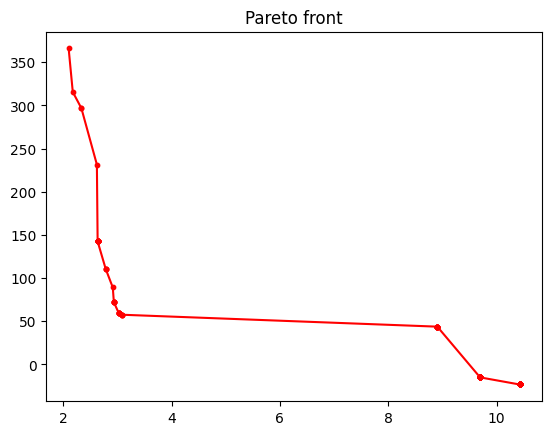

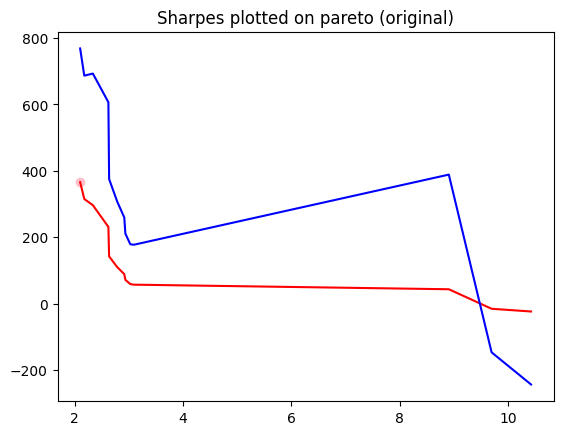

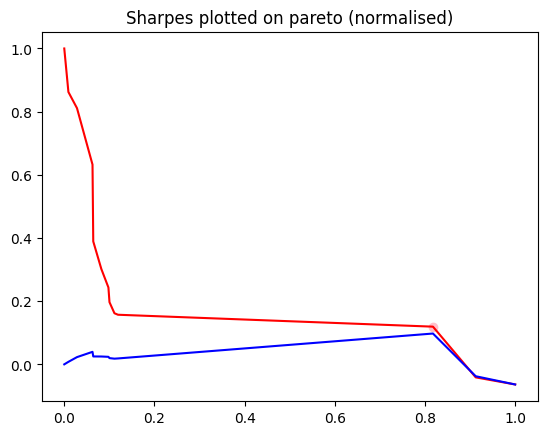

In [11]:
# Finding optimal sharpe ratio from Pareto front

#calculates normalised data
weighted_x = [(i-min(pareto_x))/(max(pareto_x)-min(pareto_x)) for i in pareto_x]
weighted_y = [(i)/max(pareto_y) for i in pareto_y]

plt.figure() #plots just the pareto front
plt.scatter(x=pareto_x, y=pareto_y, color='red', label='Pareto Set', s=10)
plt.title('Pareto front')

for i in range(len(pareto_x)-1):
    plt.plot([pareto_x[i], pareto_x[i+1]], [pareto_y[i], pareto_y[i+1]], color='red')

plt.figure() #plots the pareto font and the sharpes ratio and highlights in pink where the optimal solution lies (original data)
plt.plot(pareto_x,pareto_y,color = 'red')

sharpes_ratio = []

for i in range(len(pareto_x)):
    sharpes_ratio.append(pareto_y[i]/(1/pareto_x[i]))

plt.plot(pareto_x,sharpes_ratio, color = 'blue')
index = sharpes_ratio.index(max(sharpes_ratio))
plt.scatter(pareto_x[index],pareto_y[index],color = 'pink')
plt.title('Sharpes plotted on pareto (original)')
plt.figure() #now does the same with normalised values
plt.plot(weighted_x,weighted_y,color = 'red')

sharpes_ratio = []

for i in range(len(weighted_x)):
    sharpes_ratio.append(weighted_y[i]/(1/weighted_x[i]))

plt.plot(weighted_x,sharpes_ratio, color = 'blue')
index = sharpes_ratio.index(max(sharpes_ratio))
plt.scatter(weighted_x[index],weighted_y[index],color = 'pink')
plt.title('Sharpes plotted on pareto (normalised)')

In [12]:

pareto_parameters = pd.DataFrame(columns=['Bollinger_Window', 'Bollinger_Multiplier', 'Keltner_Channel_Window',
                                          'Keltner_Channel_Multiplier', 'Stop_Loss_Pct', 'Take_Profit_Pct', 'Net_Profit', '1/Standard_Deviation','Sharpe_Ratio'])
for i in pareto_values:
        net_profit = i[0]
        inv_std_dev = i[1]
        vals = strategy_parameters[(net_profit, inv_std_dev)]

        # Append the row to the DataFrame
        pareto_parameters = pareto_parameters.append({
            'Bollinger_Window': vals[0],
            'Bollinger_Multiplier': vals[1],
            'Keltner_Channel_Window': vals[2],
            'Keltner_Channel_Multiplier': vals[3],
            'Stop_Loss_Pct': vals[4],
            'Take_Profit_Pct': vals[5],
            'Net_Profit': net_profit,
            '1/Standard_Deviation': inv_std_dev,
            'Sharpe_Ratio': net_profit/(1/inv_std_dev)
        }, ignore_index=True)

pareto_parameters.sort_values(by=['Sharpe_Ratio'])
pareto_parameters

,Bollinger_Window,Bollinger_Multiplier,Keltner_Channel_Window,Keltner_Channel_Multiplier,Stop_Loss_Pct,Take_Profit_Pct,Net_Profit,1/Standard_Deviation,Sharpe_Ratio
0,18.000000,3.040629,19.000000,1.655922,0.118387,0.766441,3.658752,2.100505,7.685229
1,17.003464,2.948147,18.709938,1.655922,0.097229,0.766441,3.154398,2.176965,6.867015
2,18.000000,3.116033,19.000000,1.742542,0.097229,0.532271,2.967483,2.335236,6.929772
3,18.000000,3.116033,19.000000,1.742542,0.097229,0.532271,2.967483,2.335236,6.929772
4,17.003464,2.948147,18.709938,1.655922,0.097229,0.460213,2.313799,2.621741,6.066184
...,...,...,...,...,...,...,...,...,...
143,18.329264,3.436748,19.000000,1.538881,0.076117,0.121669,-0.233186,10.422264,-2.430329
144,18.329264,3.436748,19.000000,1.538881,0.076117,0.121669,-0.233186,10.422264,-2.430329
145,18.329264,3.436748,19.000000,1.538881,0.076117,0.121669,-0.233186,10.422264,-2.430329
146,18.329264,3.436748,19.000000,1.538881,0.076117,0.121669,-0.233186,10.422264,-2.430329


Long return: 0.12331620582581704, current total: 1.1008498817093006
Long return: 0.1280168713626193, current total: 1.2169416946175222
Short return: 0.13753281798096406, current total: 1.356624892892864
Short return: 0.21781724421535853, current total: 1.6190787647268086
Short return: 0.15173972016094384, current total: 1.8274621769368815
Short return: 0.12316487845314361, current total: 2.011490507160289
Short return: 0.11151896011464468, current total: 2.191093640063298
Long return: 0.11240497925311232, current total: 2.388635805711915
Long return: 0.12530889314530147, current total: 2.634194052359852
Total Return: 263.42'
'Net Profit: 163.42%'
'Risk: 48.48%


(1.634194052359852, 0.4847510321256443, False)

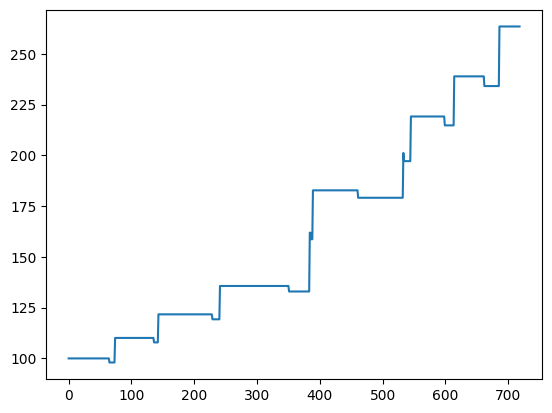

In [13]:
# To see how each of the results in the pareto front perform, simply copy a row's values from 'Bollinger_Window' to 'Take_Profit_Pct' into the strategy parameters.
# This is the strategy's performance with parameter values that generated the highest sharpe ratio
strategy(df, 17.403986,	1.893866,	18.000000,	2.855416,	0.138016,	0.105421, visualise=True)

Long return: 0.12471900447299, current total: 1.10222462438353
Long return: -0.18225091751107825, current total: 0.8833163117806015
Short return: 0.20068792072413366, current total: 1.0393754812188898
Short return: -0.1841816981976686, current total: 0.830982709222516
Long return: -0.14729180660008578, current total: 0.6944140494331439
Short return: 0.1476167399391899, current total: 0.7809827638268673
Short return: 0.1431918566111443, current total: 0.8749568730453283
Long return: 0.11697626372436676, current total: 0.9577599377946434
Short return: 0.1427799054213752, current total: 1.072618634906758
Short return: -0.14616878916290454, current total: 0.897518562452692
Long return: -0.18320383848869426, current total: 0.7184279223625739
Short return: -0.15103695845484533, current total: 0.5977203790178991
Long return: -0.1491410824625543, current total: 0.4984042003876165
Total Return: 49.84'
'Net Profit: -50.16%'
'Risk: 47.66%
t-statistic: 3.205328320746406
p-value: 0.0075574400884285

(-0.5015957996123834, 0.47657768958963137, False)

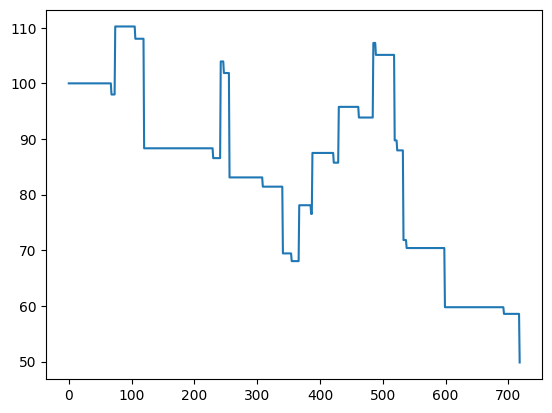

In [28]:
# Ethereum test
ohlcv = fetch_data('1d', 'ETH/AUD')
df_eth = pd.DataFrame(ohlcv)
df_eth.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
df_eth['time'] = pd.to_datetime(df_eth['time'], unit='ms')
strategy(df_eth,17.403986,	1.893866,	18.000000,	2.855416,	0.138016,	0.105421, visualise=True)